In [1]:
# Usual suspect
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sys
import functools
import math
from fastprogress import progress_bar
from typing import List
sys.path.insert(1, '../muograph/')

![alternative text](../images/muograph_logo.png)

<h1><center>Binned Clustered Clgorithm: tutorial</center></h1>


The `BCA` class is used to run the binned clustered algorithnm, as implemented in: A binned clustering algorithm to detect high-Z material using cosmic muons, 2013 JINST 8 P10013, (http://iopscience.iop.org/1748-0221/8/10/P10013). This class inherits from the `POCA` class, and share all of its attributes. As a consequence, `BCA` requires only 2 arguments:

 - `tracks`: an instance of the `Track` class.
 - `cut_low_theta`:`float` the value of the low scattering angle event cut, used to avoid errors during the POCA point computation.
 - `output_dir`:`str` the directory where to save the analysis.
 
When an instance of `BCA` is created, the `__init__` method of the `POCA` class is ran. POCA locations are computed and indices of the associated voxels are found. They will then be used by the `BCA` class. 

In [2]:
# Volume of interest
from volume.Volume_Interest import VolumeInterest
VOI = VolumeInterest(position = [0,0,835],
                     dimension=[400,1000,300],
                     voxel_width=20)
# read files
from utils.read_file import hits_csv_to_tensor
filename = "../data/Wooden_statue_copper_cylinder/DataCu.csv"
hits,E = hits_csv_to_tensor(filename=filename)

# tracking
from tracking.Tracking import Tracking
tracks = Tracking(hits=hits,voi=VOI,E=E)


Tracking in progress


Tracking done
Scattering angles computation done


In [4]:
from reconstruction.binned_clustered import BCA
bca = BCA(tracks=tracks,output_dir="../data/test/")


../data/test/POCA/ directory created

Total # event =  237887
# event after removing low theta events =  89065




Assigning voxel to each POCA point:


DONE


Now that an instance of the `BCA` class has been created, one can run the BCA algorithm using the bca_reconstruction method. It takes as arguments:

 - `n_max_per_vox:int` The maximum number of POCAs to be included within the voxel metric distribution computation. If n_max_per_vox=50, only the 50 highest scattering angle events will be taken into account.
 - `n_min_per_vox:int` The minimum number of POCAs to be included within the voxel metric distribution computation. If n_min_per_vox=5 and a voxel only contains 3 poca points, no distribution will be coimputed and the voxel final score will be set to 0.
 - `dtheta_range:Tuple[float]` The cut on scattering angle in $\text{rad}$. Before running the algorithm, all events with scattering angle $d\theta <$ `dtheta_range[0]` and $d\theta >$ `dtheta_range[1]` will be discarded. 
 - `p_range:Tuple[int]` The cut on momentum in $\text{MeV}$. Before running the algorithm, all events with momentum $p <$ `p_range[0]` and $p >$ `p[1]` will be discarded. If momentum is not available, no cut is performed.
 - `metric_method:functools.partial` The function used to compute $f(\tilde{m}_{ij})$, the value to be appened to the voxel distribution. In the publication, the function used is natural log $ln$. If`None`, $m_{ij}$ is appened directly to the voxel distribution $\mathcal{D}$.
 - `score_method:functools.partial` The function used to compute voxel final score $g(\mathcal{D})$ from the voxel distribution $\mathcal{D}$. The default function
 - `use_p:bool` If `True`, voxel metric computed as $\tilde{m}_{ij} = \frac{m_{ij}}{\theta_i p_i \cdot \theta_j p_j}$. If `False`, $\tilde{m}_{ij} = \frac{m_{ij}}{\theta_i  \cdot \theta_j }$.
 - `save:bool` If `True`, an instance of the class is saved in `self.output_dir/bca_title/`.
 - `plot:bool` If `True`, the final scores are ploted and saved in `self.output_dir/bca_title/`.

For more details, checkout the google slides document in `Muograph/presentations/`


../data/test/method_median_metric_log_0.00_1.05_rad_0_250000_MeV_n_min_max_5_50_use_p_False/ directory created



Assigning score to voxels:


/home/geant/Desktop/Muograph/tutorials/../muograph/reconstruction/binned_clustered.py:63: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  return torch.sqrt(torch.sum(torch.square(pocas - pocas.T), axis=1))


Computing final voxels score:


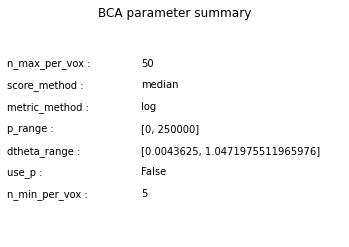

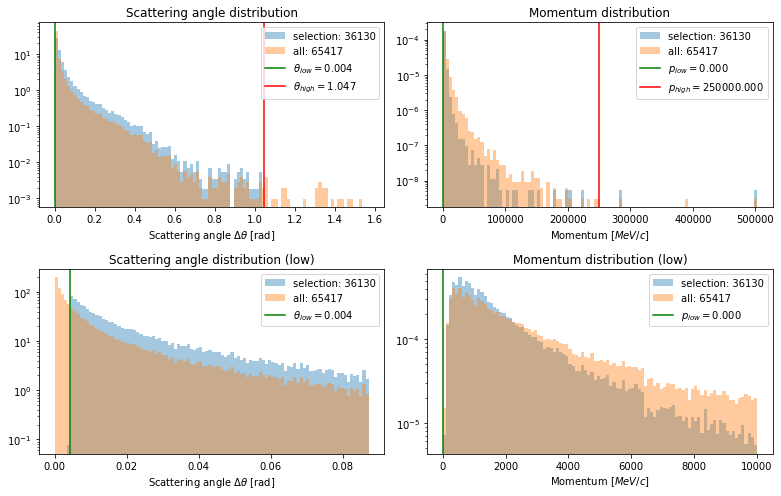

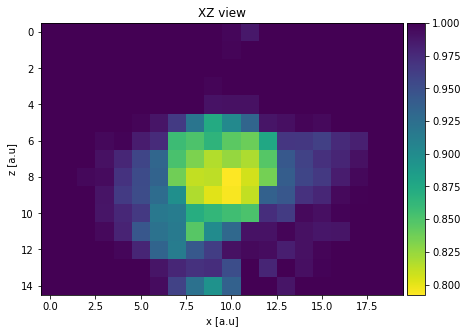

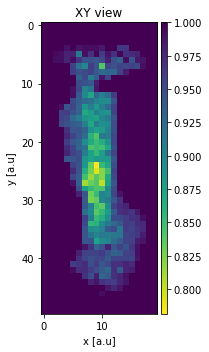

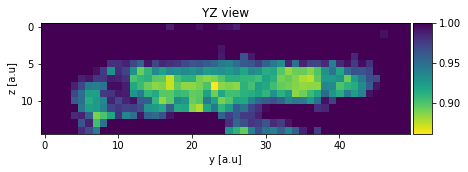

In [5]:
bca.bca_reconstruction(n_max_per_vox=50,
                       n_min_per_vox=5,
                       dtheta_range=[0.01745/4,math.pi/3],
                       p_range=[0,250000],
                       metric_method=functools.partial(torch.log),
                       score_method=functools.partial(torch.median),
                       use_p=False,
                       save=False,
                       plot=True)

### Final scores

The final voxels scores are stored in the `final_scores` attribute of the `bca` class. They are then normalized such that $\text{max}(\text{final scores}) = 1$ and $\text{min}(\text{final scores}) = 0$, and stored in the `normalized_scores` attribute.

Finally, the score of voxels containing a number of POCA points inferior to `n_min_per_vox` is set to 1.

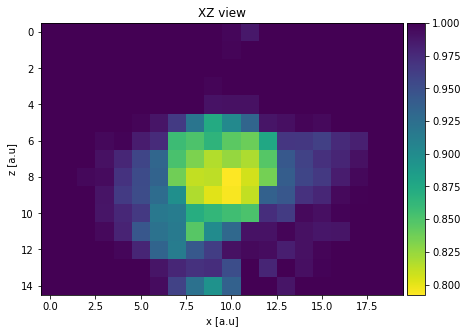

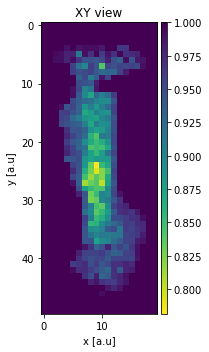

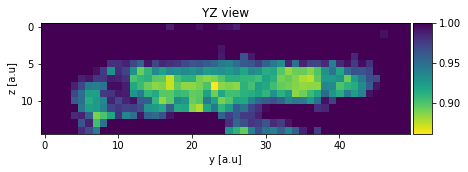

In [7]:
from plotting.Plotting import plot_VOI_pred
plot_VOI_pred(bca.normalized_scores,reverse=True)

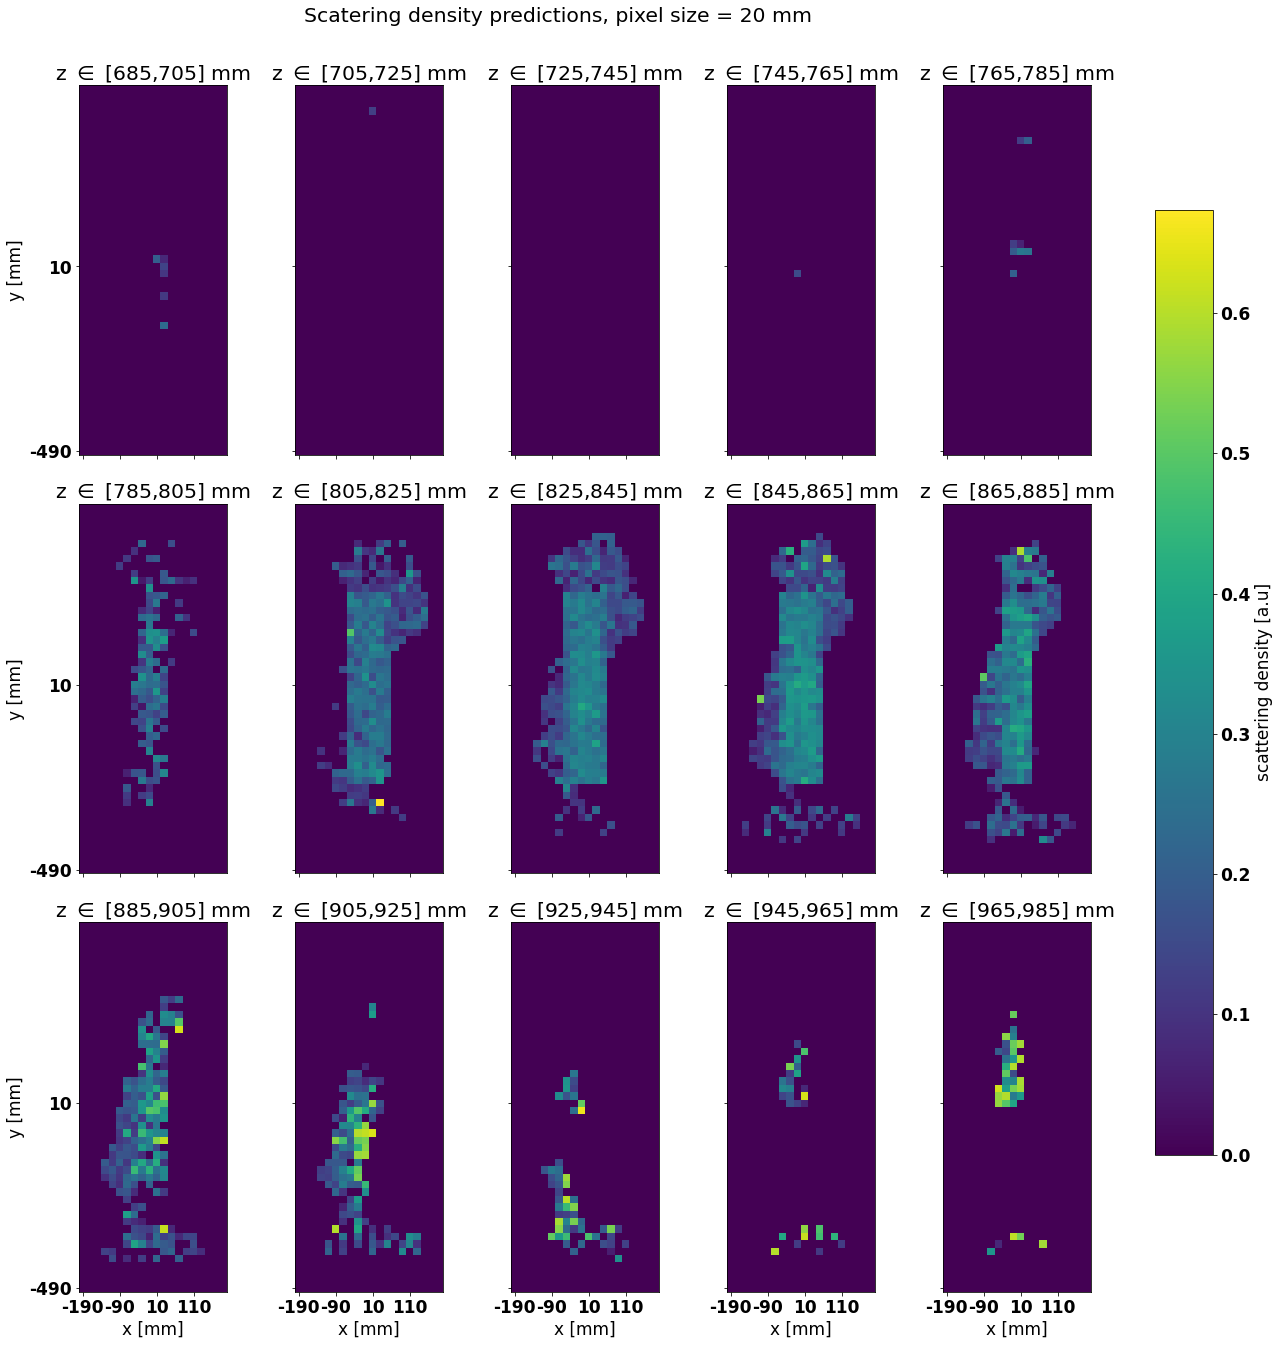

In [9]:
from plotting.Plotting import plot_voi_pred_by_voi_slice

plot_voi_pred_by_voi_slice(preds=1-bca.normalized_scores, 
                           VOI=VOI, 
                           dim=2, 
                           ncols=5, 
                           scale=5)

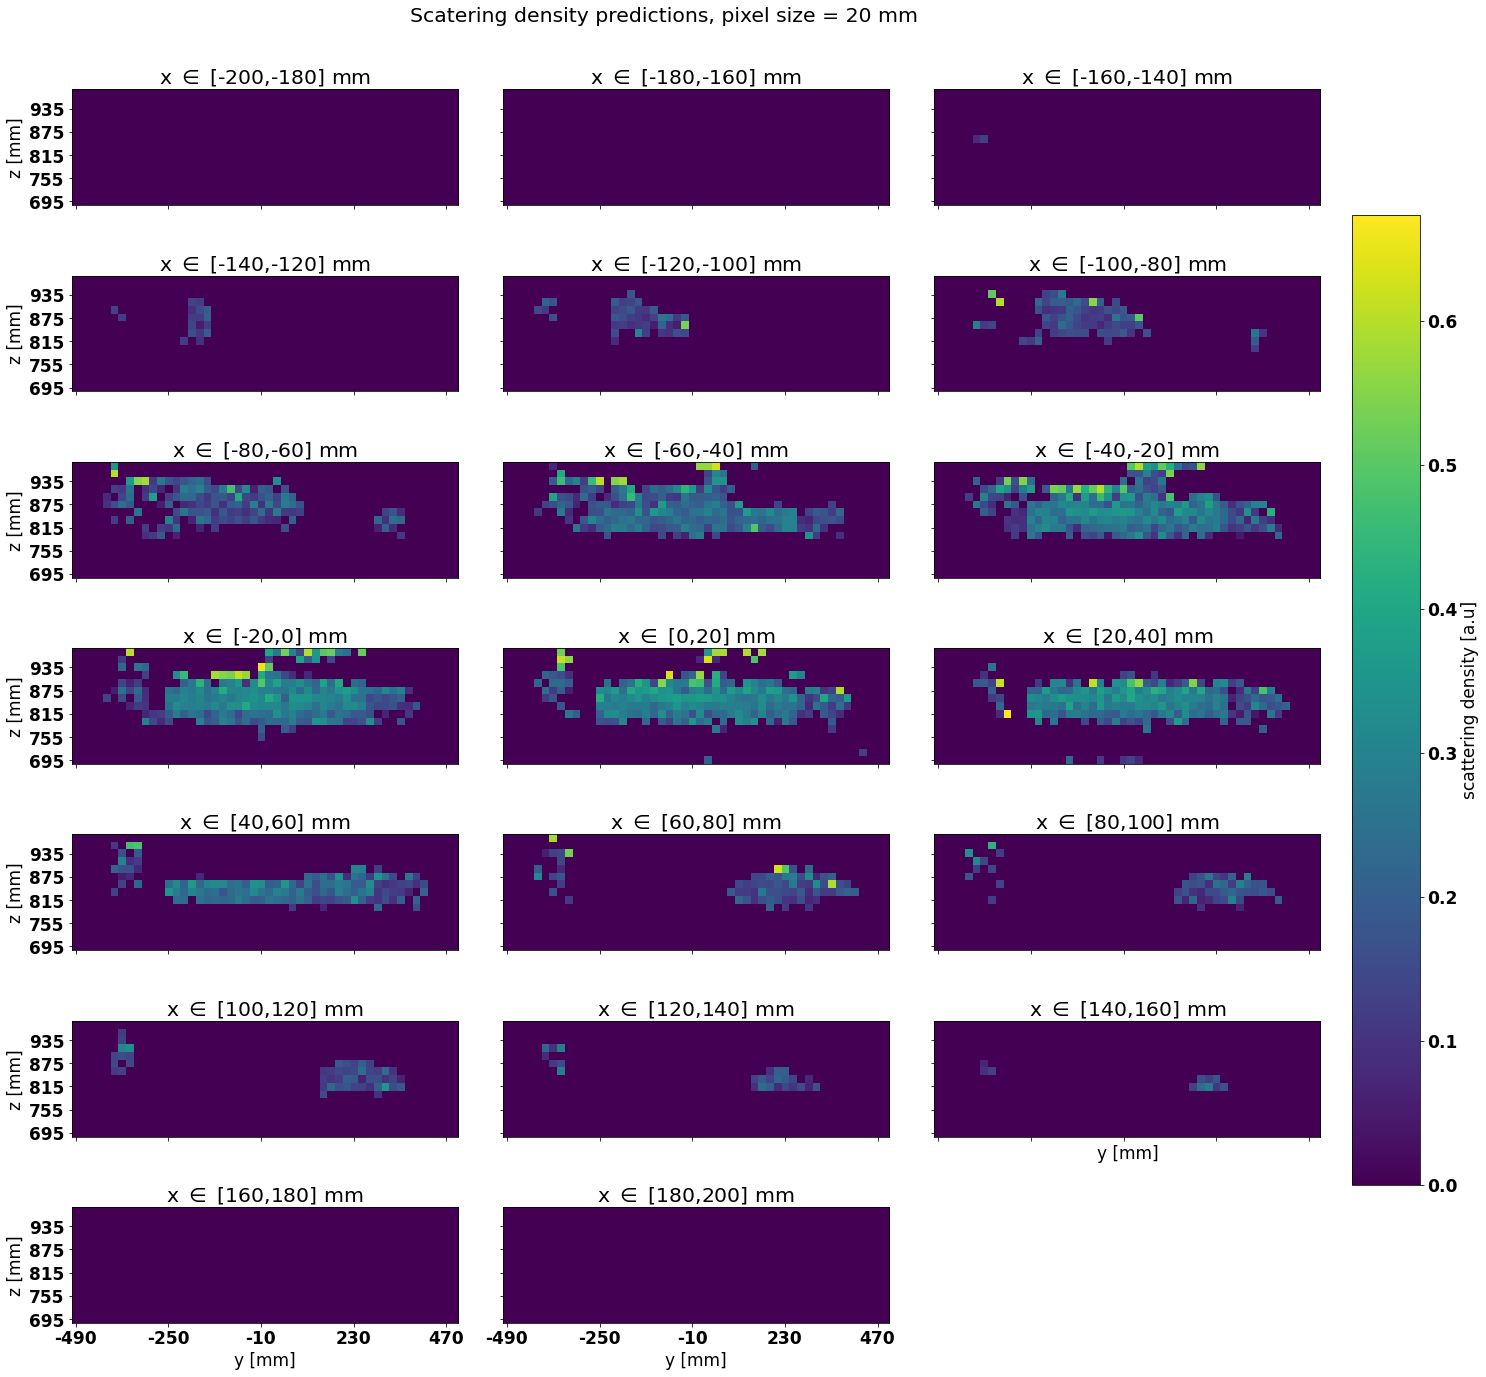

In [11]:
from plotting.Plotting import plot_voi_pred_by_voi_slice

plot_voi_pred_by_voi_slice(preds=1-bca.normalized_scores, 
                           VOI=VOI, 
                           dim=0, 
                           ncols=3, 
                           scale=5)

### Voxel distribution

We can also access the weight distribution of eeach individual voxel. They are stored in the `score_list` attribute. 

Let's have a look at the weight distribution of voxel with indices $i_x,i_y,i_z = 10,25,9$. This voxel is belongs to the copper cylinder within the statue and has a large density w.r.t the rest of the statue which is made of wood.

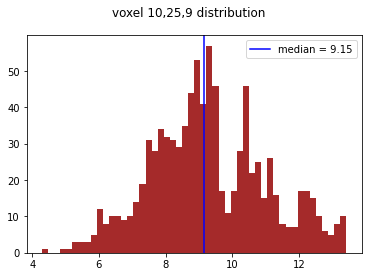

In [7]:
ix,iy,iz = 10,25,9
bca.plot_voxel_distribution([ix,iy,iz])

# bca.score_list[ix][iy][iz]

As a comparision, here is the voxel distribution of a voxel made of wood:

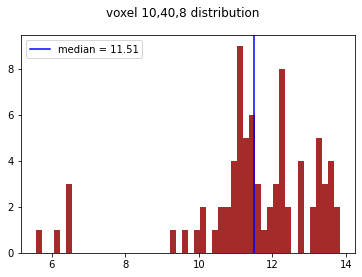

In [8]:
ix,iy,iz = 10,40,8
bca.plot_voxel_distribution([ix,iy,iz])

# bca.score_list[ix][iy][iz]